# Data Processing 

In [3]:
# Import packages
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow.keras.utils import Sequence
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing.image import load_img, img_to_array

import tensorflow as tf
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.models import Model


### Data Preprocessing 

In the following code block I've taken the pitch and yaw angles from each of the text files and merged them into a singular dataframe with additional columns for a video and frame index. 

In [19]:
# Path to the directory containing the text files
directory = 'labeled'

# List to store the data (video, frame, pitch, yaw)
data = []

# Iterate over all files in the directory
for filename in os.listdir(directory):
    if filename.endswith(".txt"):
        # Extract the video title from the filename (e.g., "video1")
        video_title = filename.split('.')[0]
        
        # Create the full file path
        filepath = os.path.join(directory, filename)
        
        # Open and read the contents of the text file
        with open(filepath, 'r') as file:
            content = file.read().strip()
            
            # Assuming the content contains alternating pitch and yaw values for each frame
            values = list(map(float, content.split()))
            
            # Iterate over the values two at a time (pitch, yaw) and generate frame data
            for i in range(0, len(values), 2):
                frame_number = i // 2  # Frame index
                pitch = values[i]
                yaw = values[i + 1]
                
                # Append a row of data (video title, frame number, pitch, yaw) to the list
                data.append([video_title, frame_number, pitch, yaw])

# Create a DataFrame from the data
df = pd.DataFrame(data, columns=['video', 'frame', 'pitch', 'yaw'])



In [8]:
# Define paths
extracted_frames_dir = 'extracted_frames'
labeled_dir = 'labeled'
unlabeled_dir = 'unlabeled'

# Function to load image paths and corresponding labels
def load_labeled_data(extracted_frames_dir, labeled_dir):
    image_paths = []
    pitches = []
    yaws = []
    
    # Iterate over each labeled video
    for video_id in range(5):  # Videos 0 to 4
        video_folder = f"video_{video_id}"
        video_frames_dir = os.path.join(extracted_frames_dir, video_folder)
        label_file = os.path.join(labeled_dir, f"{video_id}.txt")
        
        if not os.path.exists(label_file):
            print(f"Warning: Label file {label_file} does not exist.")
            continue
        
        # Load labels from the txt file
        labels = np.loadtxt(label_file)
        if labels.ndim == 1:
            labels = labels.reshape(-1, 2)  # Ensure it's a 2D array
        
        # Check number of frames and labels match
        frame_files = sorted([f for f in os.listdir(video_frames_dir) if f.endswith('.jpg')])
        num_frames = len(frame_files)
        num_labels = labels.shape[0]
        
        if num_frames != num_labels:
            print(f"Warning: Number of frames ({num_frames}) and labels ({num_labels}) do not match for video {video_id}.")
            min_length = min(num_frames, num_labels)
            frame_files = frame_files[:min_length]
            labels = labels[:min_length]
        
        # Assign labels to each frame
        for frame_file, (pitch, yaw) in zip(frame_files, labels):
            frame_path = os.path.join(video_frames_dir, frame_file)
            image_paths.append(frame_path)
            pitches.append(pitch)
            yaws.append(yaw)
    
    return np.array(image_paths), np.array(pitches), np.array(yaws)

# Load all labeled data
image_paths, pitches, yaws = load_labeled_data(extracted_frames_dir, labeled_dir)

print(f"Total labeled frames: {len(image_paths)}")

# Optionally, remove frames with NaN labels if any (assuming some labels might be NaN)
valid_indices = ~np.isnan(pitches) & ~np.isnan(yaws)
image_paths = image_paths[valid_indices]
pitches = pitches[valid_indices]
yaws = yaws[valid_indices]

print(f"Total labeled frames after removing NaNs: {len(image_paths)}")


Total labeled frames: 5996
Total labeled frames after removing NaNs: 5019


---

### Data Augmentation

In [9]:
class DataGenerator(Sequence):
    def __init__(self, image_paths, pitches, yaws, batch_size=32, img_size=(224, 224), augment=False):
        self.image_paths = image_paths
        self.pitches = pitches
        self.yaws = yaws
        self.batch_size = batch_size
        self.img_size = img_size
        self.augment = augment
        if self.augment:
            self.aug = ImageDataGenerator(
                rotation_range=20,
                width_shift_range=0.1,
                height_shift_range=0.1,
                shear_range=0.1,
                zoom_range=0.1,
                horizontal_flip=True,
                fill_mode='nearest'
            )
        else:
            self.aug = ImageDataGenerator()
    
    def __len__(self):
        return int(np.ceil(len(self.image_paths) / self.batch_size))
    
    def __getitem__(self, idx):
        batch_x = self.image_paths[idx * self.batch_size:(idx + 1) * self.batch_size]
        batch_pitches = self.pitches[idx * self.batch_size:(idx + 1) * self.batch_size]
        batch_yaws = self.yaws[idx * self.batch_size:(idx + 1) * self.batch_size]
        
        images = []
        for img_path in batch_x:
            img = load_img(img_path, target_size=self.img_size)
            img = img_to_array(img)
            images.append(img)
        
        images = np.array(images, dtype='float32') / 255.0  # Normalize
        
        if self.augment:
            # Apply augmentation
            images = self.aug.flow(images, batch_size=self.batch_size, shuffle=False).next()
        
        return images, np.stack([batch_pitches, batch_yaws], axis=1)


# Parameters
batch_size = 32
img_size = (224, 224)

# Create Data Generator without augmentation
train_gen = DataGenerator(
    image_paths=image_paths,
    pitches=pitches,
    yaws=yaws,
    batch_size=batch_size,
    img_size=img_size,
    augment=False  # No augmentation
)



---

### Model Definition 

Transfer learning with pre-trained model with options including: 
- ResNet * (specifically ResNet50)
- EfficientNet * (specifically EfficientNetB0)
- MobileNet 
- Inception Networks

In [4]:
# Constructing the EffificentNetB0 Model 

# Define image size and batch size
img_size = (224, 224)  # EfficientNetB0 expects 224x224 images
batch_size = 32

# Load the pre-trained EfficientNetB0 model without the top classification layer
base_model = EfficientNetB0(weights='imagenet', include_top=False, input_shape=(*img_size, 3))

# Freeze the base model to prevent its weights from being updated during initial training
base_model.trainable = False

# Add a global spatial average pooling layer
x = base_model.output
x = GlobalAveragePooling2D()(x)

# Add a fully connected layer
x = Dense(1024, activation='relu')(x)
x = Dropout(0.5)(x)

# Add another fully connected layer
x = Dense(512, activation='relu')(x)
x = Dropout(0.5)(x)

# Add the final output layer with 2 neurons (pitch and yaw) and linear activation for regression
predictions = Dense(2, activation='linear')(x)

# Define the complete model
model = Model(inputs=base_model.input, outputs=predictions)

# Compile the model with Mean Squared Error loss and Adam optimizer
model.compile(optimizer='adam', loss='mse', metrics=['mae'])

# Display the model architecture
model.summary()


16705208/16705208 [==============================] - 4s 0us/step
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 rescaling (Rescaling)       (None, 224, 224, 3)          0         ['input_1[0][0]']             
                                                                                                  
 normalization (Normalizati  (None, 224, 224, 3)          7         ['rescaling[0][0]']           
 on)                                                                                              
                                                                                                  
 rescaling_1 (Rescaling)     

In [18]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# Define callbacks
early_stop = EarlyStopping(monitor='loss', patience=10, restore_best_weights=True)
checkpoint = ModelCheckpoint('models/best_efficientnet_model.h5', monitor='loss', save_best_only=True)

# Train the model
#epochs = 50
epochs = 3


history = model.fit(
    train_gen,                    # Your DataGenerator instance without augmentation
    epochs=epochs,
    callbacks=[early_stop, checkpoint]
)


Epoch 1/3
157/157 [==============================] - ETA: 0s - loss: 4.0009e-04 - mae: 0.0160

/Users/shaemckenna1/Documents/Career/comma/openenv/lib/python3.8/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


157/157 [==============================] - 194s 1s/step - loss: 4.0009e-04 - mae: 0.0160
Epoch 2/3
157/157 [==============================] - 199s 1s/step - loss: 3.9287e-04 - mae: 0.0159
Epoch 3/3
157/157 [==============================] - 186s 1s/step - loss: 3.9016e-04 - mae: 0.0156


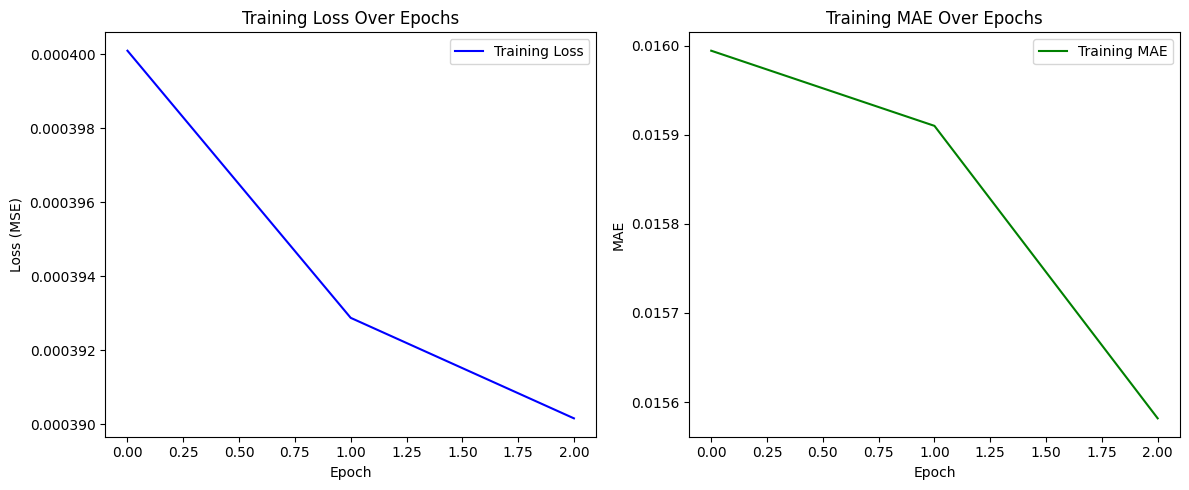

157/157 [==============================] - 181s 1s/step


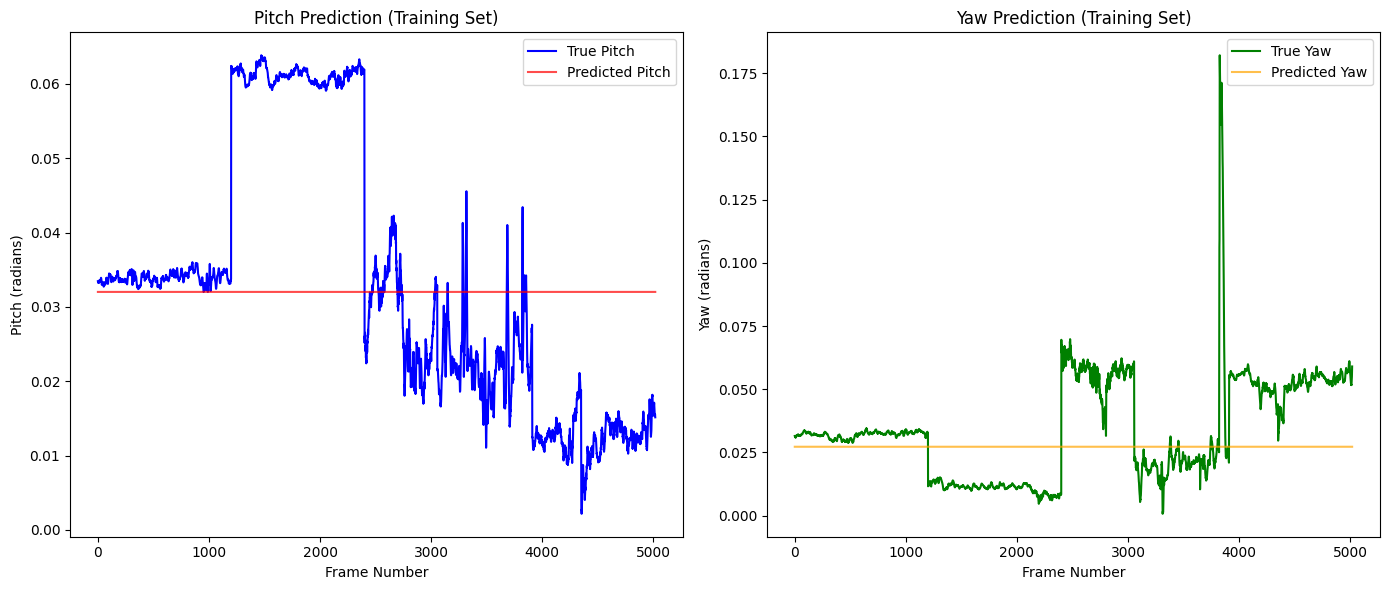

In [19]:
import matplotlib.pyplot as plt

# Plot training loss and MAE
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss', color='blue')
#plt.plot(history_fine.history['loss'], label='Fine-Tuning Loss', color='orange')
plt.xlabel('Epoch')
plt.ylabel('Loss (MSE)')
plt.title('Training Loss Over Epochs')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['mae'], label='Training MAE', color='green')
#plt.plot(history_fine.history['mae'], label='Fine-Tuning MAE', color='red')
plt.xlabel('Epoch')
plt.ylabel('MAE')
plt.title('Training MAE Over Epochs')
plt.legend()

plt.tight_layout()
plt.show()

# Visualize predictions on training data
train_predictions = model.predict(train_gen, verbose=1)
train_pred_pitches = train_predictions[:, 0]
train_pred_yaws = train_predictions[:, 1]

# Function to plot predictions vs actual
def plot_predictions(true_pitches, true_yaws, pred_pitches, pred_yaws, title_suffix=''):
    plt.figure(figsize=(14, 6))
    
    plt.subplot(1, 2, 1)
    plt.plot(true_pitches, label='True Pitch', color='blue')
    plt.plot(pred_pitches, label='Predicted Pitch', color='red', alpha=0.7)
    plt.xlabel('Frame Number')
    plt.ylabel('Pitch (radians)')
    plt.title(f'Pitch Prediction {title_suffix}')
    plt.legend()
    
    plt.subplot(1, 2, 2)
    plt.plot(true_yaws, label='True Yaw', color='green')
    plt.plot(pred_yaws, label='Predicted Yaw', color='orange', alpha=0.7)
    plt.xlabel('Frame Number')
    plt.ylabel('Yaw (radians)')
    plt.title(f'Yaw Prediction {title_suffix}')
    plt.legend()
    
    plt.tight_layout()
    plt.show()

# Plot for training data
plot_predictions(pitches, yaws, train_pred_pitches, train_pred_yaws, title_suffix='(Training Set)')
